#### What DIC and ALK observations are available in GLODAPv2.2021? how are they distributed in space and time? 

#### How does the evaluation of (regridded) DIC and ALK from T001(NCEP), M001(MetOffice) runs compare by season and depth?


In [178]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [179]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [180]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [181]:
#load data, extract only the data you need
runhorse = False
if runhorse:

    tdir = '/gpfs/home/mep22dku/scratch/'
    glodap = pd.read_csv(f'{tdir}GLODAPv2.2021_Merged_Master_File.csv')
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    #print(glodap.head())

    tDIC = np.array(glodap['G2tco2'][:])
    tco2f = np.array(glodap['G2tco2f'][:])
    tco2qc = np.array(glodap['G2tco2qc'][:])

    tALK = np.array(glodap['G2talk'][:])
    talkf = np.array(glodap['G2talkf'][:])
    tco2f = np.array(glodap['G2tco2f'][:])

    tSAL = np.array(glodap['G2salinity'][:])
    tTEMP = np.array(glodap['G2temperature'][:])
    tPRES = np.array(glodap['G2pressure'][:])
    tLAT = np.array(glodap['G2latitude'][:])
    tLON = np.array(glodap['G2longitude'][:])
    tYEAR = np.array(glodap['G2year'])
    tMONTH = np.array(glodap['G2month'])
    #tAOU = np.array(glodap['aou'][:])

    dens = seawater.dens(tSAL,tTEMP,tPRES)
    tDIC=tDIC*dens/1000
    tALK=tALK*dens/1000

    tALK_DIC = tALK-tDIC
    tALK_DIC2 = tALK-(tDIC+50)

    tfilt = (tLAT <= -50) & (tco2f < 9) & (talkf <9) & ~np.isnan(tDIC) & ~np.isnan(tALK) 
    tDIC_SO = tDIC[tfilt]
    print(np.nanmin(tDIC_SO))
    tco2f_SO =  tco2f[tfilt]
    tco2qc_SO = tco2qc[tfilt]
    tALK_SO = tALK[tfilt]
    talkf_SO = talkf[tfilt]
    tco2f_SO = tco2f[tfilt]

    tSAL_SO = tSAL[tfilt]
    tTEMP_SO = tTEMP[tfilt]
    tPRES_SO = tPRES[tfilt]
    tLAT_SO = tLAT[tfilt]
    tLON_SO = tLON[tfilt]
    tYEAR_SO = tYEAR[tfilt]
    tMONTH_SO = tMONTH[tfilt]
    tSECT_SO = np.zeros_like(tLON_SO)
    tSECT_SO[(tLON_SO <= -67) | (tLON_SO > 150)] = 4 #pacific
    tSECT_SO[(tLON_SO <= 20) &(tLON_SO > -67)] = 2 #atl
    tSECT_SO[(tLON_SO > 20) &(tLON_SO <= 150)] = 3 #indian

    print(np.shape(tYEAR_SO))
    df = pd.DataFrame([tYEAR_SO,tMONTH_SO,tDIC_SO,tALK_SO,tSAL_SO,tTEMP_SO,tPRES_SO,tLAT_SO,tLON_SO,tSECT_SO]).T
    # df = df.sort_values(by = tYEAR_SO)
    df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'SECT']
    df.to_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL.csv')


In [182]:
df = pd.read_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL.csv')
df = df.sort_values(by = 'YR')

tDIC_SO = np.array(df['DIC'][:])
tALK_SO = np.array(df['ALK'][:])


tSAL_SO = np.array(df['SAL'][:])
tTEMP_SO = np.array(df['TEMP'][:])
tPRES_SO = np.array(df['PRES'][:])
tLAT_SO = np.array(df['LAT'][:])
tLON_SO = np.array(df['LON'][:])
tYEAR_SO = np.array(df['YR'])
tMONTH_SO = np.array(df['MONTH'])
tSECT_SO = np.array(df['SECT'])


In [183]:
yrs = np.arange(1972,2021,1)
OBS_depths = np.zeros([5,len(yrs)])
OBS_seas = np.zeros([4,len(yrs)])
OBS_lats = np.zeros([6,len(yrs)])
OBS_sects = np.zeros([3,len(yrs)])

for i in range(0,len(yrs)):
    tyr = yrs[i]

    OBS_depths[0,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO<=200)])
    OBS_depths[1,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>200) & (tPRES_SO<=500)]) 
    OBS_depths[2,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>500) & (tPRES_SO<=1000)]) 
    OBS_depths[3,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>1000) & (tPRES_SO<=3000)]) 
    OBS_depths[4,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>3000)]) 
    
    #spring
    OBS_seas[0,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tMONTH_SO<=11) & (tMONTH_SO>8)]) #spring
    OBS_seas[1,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & ((tMONTH_SO==12) | (tMONTH_SO<=2))])  #sumer
    OBS_seas[2,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tMONTH_SO>2) & (tMONTH_SO<=5)]) #autum
    OBS_seas[3,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tMONTH_SO>5) & (tMONTH_SO<=8)]) #winter
    
    #sectors
#spring
    OBS_sects[0,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tSECT_SO == 2)]) #atl
    OBS_sects[1,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tSECT_SO == 3)])  #ind
    OBS_sects[2,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & ((tSECT_SO == 4))]) #pac  

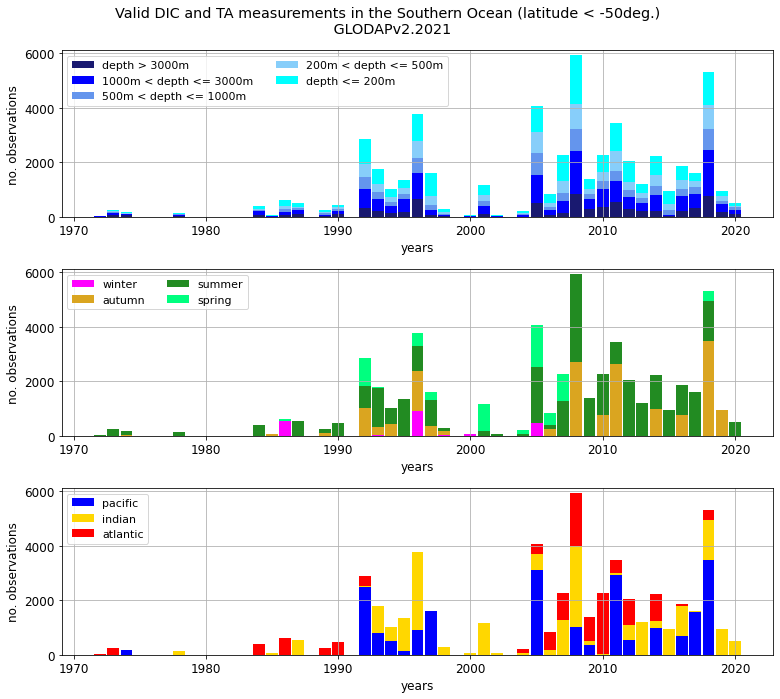

In [184]:
fact = 0.55
fig, axs = plt.subplots(3,1, figsize=(20*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fs = 11
width = 0.9
axs[0].bar(yrs,OBS_depths[4,:],width, color = 'midnightblue', label = 'depth > 3000m')
axs[0].bar(yrs,OBS_depths[3,:],width, bottom = OBS_depths[4,:], color = 'b', label = '1000m < depth <= 3000m')
axs[0].bar(yrs,OBS_depths[2,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:], color = 'cornflowerblue', label = '500m < depth <= 1000m')
axs[0].bar(yrs,OBS_depths[1,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:], color = 'lightskyblue', label = '200m < depth <= 500m')
axs[0].bar(yrs,OBS_depths[0,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:]+OBS_depths[1,:], color = 'cyan', label = 'depth <= 200m')
axs[0].legend(ncol = 2, loc = 'best', fontsize = fs)

axs[1].bar(yrs,OBS_seas[3,:],width,  color = 'magenta', label = 'winter')
axs[1].bar(yrs,OBS_seas[2,:],width, bottom = OBS_seas[3,:], color = 'goldenrod', label = 'autumn')
axs[1].bar(yrs,OBS_seas[1,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:], color = 'forestgreen', label = 'summer')
axs[1].bar(yrs,OBS_seas[0,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:]+OBS_seas[1,:], color = 'springgreen', label = 'spring')
axs[1].legend(ncol = 2, loc = 'best', fontsize = fs)

axs[2].bar(yrs,OBS_sects[2,:],width,  color = 'b', label = 'pacific')
axs[2].bar(yrs,OBS_sects[1,:],width, bottom = OBS_sects[2,:], color = 'gold', label = 'indian')
axs[2].bar(yrs,OBS_sects[0,:],width, bottom = OBS_sects[2,:]+OBS_sects[1,:], color = 'r', label = 'atlantic')
axs[2].legend(ncol = 1, loc = 'best', fontsize = fs)
# ax.bar(x, diat_means, width, yerr=men_std, label='diat',color = 'r', alpha = 0.8)
# ax.bar(x, flag_means, width, yerr=women_std, bottom=diat_means,
#        label='flag', color = 'r', hatch='.', alpha = 0.6)

for i in range(0,3):
    axs[i].set_ylim([0,6100])
    axs[i].grid()
    axs[i].set_xlabel('years'); axs[i].set_ylabel('no. observations')

plt.suptitle('Valid DIC and TA measurements in the Southern Ocean (latitude < -50deg.) \n GLODAPv2.2021')
plt.tight_layout()

In [185]:
# now = datetime.now()
# print(now)

# td = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/WOA_DIC_1990_all.nc')
# lons = (td['lon'][:]-180)
# lats = (td['lat'][:])
# depths = (td['deptht'][:])

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     arval = array[idx]
#     return(idx, arval)

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/'
# mod_dics_M001 = np.zeros_like(tDIC_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tdic = tDIC_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_dics_M001[i] = (tnc['DIC'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
#     tyrold = tyr

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001/'
# mod_dics_T001 = np.zeros_like(tDIC_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tdic = tDIC_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_dics_T001[i] = (tnc['DIC'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
#     tyrold = tyr
    
# now2 = datetime.now()
# print(now2-now)


In [186]:
# now = datetime.now()
# print(now)

# td = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/WOA_Alkalini_1990_all.nc')
# lons = (td['lon'][:]-180)
# lats = (td['lat'][:])
# depths = (td['deptht'][:])

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     arval = array[idx]
#     return(idx, arval)

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/'
# mod_ALKs_M001 = np.zeros_like(tALK_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tALK = tALK_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_Alkalini_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_Alkalini_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_ALKs_M001[i] = (tnc['Alkalini'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
#     tyrold = tyr

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001/'
# mod_ALKs_T001 = np.zeros_like(tALK_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tALK = tALK_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_Alkalini_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_Alkalini_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_ALKs_T001[i] = (tnc['Alkalini'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
#     tyrold = tyr
    
# now2 = datetime.now()
# print(now2-now)


In [187]:
# now = datetime.now()
# print(now)

# td = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/WOA_votemper_1990_all.nc')
# lons = (td['lon'][:]-180)
# lats = (td['lat'][:])
# depths = (td['deptht'][:])

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     arval = array[idx]
#     return(idx, arval)

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/'
# mod_TEMPs_M001 = np.zeros_like(tSAL_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tSAL = tSAL_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_votemper_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_votemper_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_TEMPs_M001[i] = (tnc['votemper'][tmonth-1,idx_d,idx_lat,idx_lon])
#     tyrold = tyr

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001/'
# mod_TEMPs_T001 = np.zeros_like(tSAL_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tSAL = tSAL_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_votemper_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_votemper_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_TEMPs_T001[i] = (tnc['votemper'][tmonth-1,idx_d,idx_lat,idx_lon])
#     tyrold = tyr
    
# now2 = datetime.now()
# print(now2-now)


In [188]:
# now = datetime.now()
# print(now)

# td = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/WOA_vosaline_1990_all.nc')
# lons = (td['lon'][:]-180)
# lats = (td['lat'][:])
# depths = (td['deptht'][:])

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     arval = array[idx]
#     return(idx, arval)

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/'
# mod_SALs_M001 = np.zeros_like(tSAL_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tSAL = tSAL_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_vosaline_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_vosaline_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_SALs_M001[i] = (tnc['vosaline'][tmonth-1,idx_d,idx_lat,idx_lon])
#     tyrold = tyr

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001/'
# mod_SALs_T001 = np.zeros_like(tSAL_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tSAL = tSAL_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_vosaline_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_vosaline_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_SALs_T001[i] = (tnc['vosaline'][tmonth-1,idx_d,idx_lat,idx_lon])
#     tyrold = tyr
    
# now2 = datetime.now()
# print(now2-now)


In [189]:

# df = pd.DataFrame([tYEAR_SO,tMONTH_SO,tDIC_SO,tALK_SO,tSAL_SO,tTEMP_SO,tPRES_SO,tLAT_SO,tLON_SO,tSECT_SO, mod_dics_M001, mod_ALKs_M001,mod_TEMPs_M001, mod_SALs_M001]).T
# df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'SECT','mod_DIC','mod_ALK','mod_TEMP','mod_SAL']
# df.to_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_model_M001.csv')
# df = pd.DataFrame([tYEAR_SO,tMONTH_SO,tDIC_SO,tALK_SO,tSAL_SO,tTEMP_SO,tPRES_SO,tLAT_SO,tLON_SO,tSECT_SO, mod_dics_T001, mod_ALKs_T001,mod_TEMPs_T001, mod_SALs_T001]).T
# df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'SECT','mod_DIC','mod_ALK','mod_TEMP','mod_SAL']
# df.to_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_model_T001.csv')

In [190]:
df_M001 = pd.read_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_model_M001.csv')
df_T001 = pd.read_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_model_T001.csv')

tSAL_SO_conv = tSAL_SO * 35.16504/35

mod_DIC_M001 = np.array(df_M001['mod_DIC'][:])
mod_ALK_M001 = np.array(df_M001['mod_ALK'][:])
mod_TEMP_M001 = np.array(df_M001['mod_TEMP'][:])
mod_SAL_M001 = np.array(df_M001['mod_SAL'][:])
mod_DIC_T001 = np.array(df_T001['mod_DIC'][:])
mod_ALK_T001 = np.array(df_T001['mod_ALK'][:])
mod_TEMP_T001 = np.array(df_T001['mod_TEMP'][:])
mod_SAL_T001 = np.array(df_T001['mod_SAL'][:])

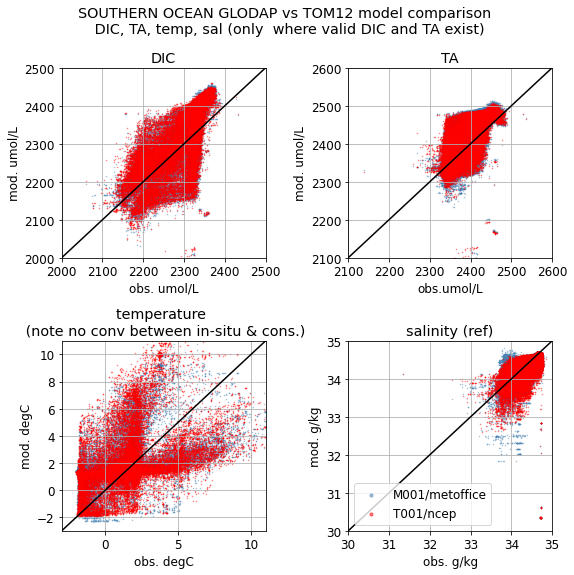

In [191]:

fact = 0.37
fig, axs = plt.subplots(2,2, figsize=(22*fact, 22*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
mcol = 'steelblue'; tcol = 'red'
axs[0].scatter(tDIC_SO,mod_DIC_M001, marker = '.', c = mcol, s = 1, alpha = 0.5, label = 'M001/metoffice')
axs[0].scatter(tDIC_SO,mod_DIC_T001, marker = '.',c = tcol,s = 1, alpha = 0.5, label = 'T001/ncep')
axs[0].plot([2000,2500],[2000,2500],'k-')
axs[1].scatter(tALK_SO,mod_ALK_M001, marker = '.',c = mcol, s = 1,alpha = 0.5, label = 'M001/metoffice')
axs[1].scatter(tALK_SO,mod_ALK_T001, marker = '.',c = tcol, s = 1,alpha = 0.5, label = 'T001/ncep')
axs[1].plot([2000,2600],[2000,2600],'k-')
axs[2].scatter(tTEMP_SO,mod_TEMP_M001, marker = '.',c = mcol, s = 1,alpha = 0.5, label = 'M001/metoffice')
axs[2].scatter(tTEMP_SO,mod_TEMP_T001, marker = '.',c = tcol, s = 1,alpha = 0.5, label = 'T001/ncep')
axs[2].plot([-3,11],[-3,11],'k-')
axs[3].scatter(tSAL_SO,mod_SAL_M001, marker = '.',c = mcol, s = 1,alpha = 0.5)
axs[3].scatter(tSAL_SO,mod_SAL_T001, marker = '.',c = tcol, s = 1,alpha = 0.5)

axs[3].scatter(10,10, marker = '.',c = mcol, s = 40,alpha = 0.5, label = 'M001/metoffice')
axs[3].scatter(10,10, marker = '.',c = tcol, s = 40,alpha = 0.5, label = 'T001/ncep')
axs[3].plot([30,35],[30,35],'k-')


xmins = [2000,2100,-3,30]
xmaxs = [2500,2600,11,35]
tits = ['DIC','TA','temperature \n (note no conv between in-situ & cons.)','salinity (ref)']
axlab = ['obs. umol/L', 'obs.umol/L', 'obs. degC','obs. g/kg']
aylab = ['mod. umol/L', 'mod. umol/L', 'mod. degC','mod. g/kg']
for i in range(0,4):
    axs[i].grid()
    axs[i].set_title(tits[i])
    axs[i].set_xlim([xmins[i],xmaxs[i]])
    axs[i].set_ylim([xmins[i],xmaxs[i]])
    axs[i].set_xlabel(axlab[i]); axs[i].set_ylabel(aylab[i])
    
axs[3].legend()
fig.suptitle('SOUTHERN OCEAN GLODAP vs TOM12 model comparison \n DIC, TA, temp, sal (only  where valid DIC and TA exist)')
plt.tight_layout()

## selected model evaluation metrics:

#### bias
- (-np.mean(obs) + np.mean(mod))

#### RMSE
- (np.sqrt(np.sum((mod - obs)^2) /len(obs)))

#### Willmott Skill Score (WSS)
- nondimensional parametric score with range 0 - 1
- roughly model error divided by the range of the observations
- xbar = np.mean(obs)
- (1-(np.sum((mod - obs)^ 2 )  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar)) ^ 2)))

In [205]:
def bias_box(obs,mod):
    bias = (-np.mean(obs) + np.mean(mod))
    return bias

def RMSE_box(obs,mod):
    RMSE = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
    return RMSE

def WSS_box(obs,mod):
    xbar = np.mean(obs)
    WSS = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
    return WSS

In [206]:
mask = ~np.isnan(mod_DIC_M001) & ~np.isnan(mod_ALK_M001)
bias_M001_DIC = bias_box(tDIC_SO[mask],mod_DIC_M001[mask])
RMSE_M001_DIC = RMSE_box(tDIC_SO[mask],mod_DIC_M001[mask])
WSS_M001_DIC = WSS_box(tDIC_SO[mask],mod_DIC_M001[mask])
bias_T001_DIC = bias_box(tDIC_SO[mask],mod_DIC_T001[mask])
RMSE_T001_DIC = RMSE_box(tDIC_SO[mask],mod_DIC_T001[mask])
WSS_T001_DIC = WSS_box(tDIC_SO[mask],mod_DIC_T001[mask])

bias_M001_ALK = bias_box(tALK_SO[mask],mod_ALK_M001[mask])
RMSE_M001_ALK = RMSE_box(tALK_SO[mask],mod_ALK_M001[mask])
WSS_M001_ALK = WSS_box(tALK_SO[mask],mod_ALK_M001[mask])
bias_T001_ALK = bias_box(tALK_SO[mask],mod_ALK_T001[mask])
RMSE_T001_ALK = RMSE_box(tALK_SO[mask],mod_ALK_T001[mask])
WSS_T001_ALK = WSS_box(tALK_SO[mask],mod_ALK_T001[mask])

In [207]:

depthmins = np.array([0.0,5,20,100,500,1000,2000])
depthmaxs = np.array([5.0,20,100,500,1000,2000,10000])
depth_tp = np.array([0, 12.5,60,300,750,1500,4000])

bias_bydepth_M001_DIC = np.zeros_like(depthmins)
RMSE_bydepth_M001_DIC = np.zeros_like(depthmins)
WSS_bydepth_M001_DIC = np.zeros_like(depthmins)
bias_bydepth_T001_DIC = np.zeros_like(depthmins)
RMSE_bydepth_T001_DIC = np.zeros_like(depthmins)
WSS_bydepth_T001_DIC = np.zeros_like(depthmins)
bias_bydepth_M001_DIC_sum = np.zeros_like(depthmins)
RMSE_bydepth_M001_DIC_sum = np.zeros_like(depthmins)
WSS_bydepth_M001_DIC_sum = np.zeros_like(depthmins)
bias_bydepth_T001_DIC_sum = np.zeros_like(depthmins)
RMSE_bydepth_T001_DIC_sum = np.zeros_like(depthmins)
WSS_bydepth_T001_DIC_sum = np.zeros_like(depthmins)
bias_bydepth_M001_DIC_wint = np.zeros_like(depthmins)
RMSE_bydepth_M001_DIC_wint = np.zeros_like(depthmins)
WSS_bydepth_M001_DIC_wint = np.zeros_like(depthmins)
bias_bydepth_T001_DIC_wint = np.zeros_like(depthmins)
RMSE_bydepth_T001_DIC_wint = np.zeros_like(depthmins)
WSS_bydepth_T001_DIC_wint = np.zeros_like(depthmins)

for i in range(0,len(depthmins)):
    mask =( ~np.isnan(mod_DIC_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i]))
    bias_bydepth_M001_DIC[i] = bias_box(tDIC_SO[mask],mod_DIC_M001[mask])
    RMSE_bydepth_M001_DIC[i] = RMSE_box(tDIC_SO[mask],mod_DIC_M001[mask])
    WSS_bydepth_M001_DIC[i] = WSS_box(tDIC_SO[mask],mod_DIC_M001[mask])
    bias_bydepth_T001_DIC[i] = bias_box(tDIC_SO[mask],mod_DIC_T001[mask])
    RMSE_bydepth_T001_DIC[i] = RMSE_box(tDIC_SO[mask],mod_DIC_T001[mask])
    WSS_bydepth_T001_DIC[i] = WSS_box(tDIC_SO[mask],mod_DIC_T001[mask]) 
    mask =( ~np.isnan(mod_DIC_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i])) & ((tMONTH_SO==12) | (tMONTH_SO<=2))
    bias_bydepth_M001_DIC_sum[i] = bias_box(tDIC_SO[mask],mod_DIC_M001[mask])
    RMSE_bydepth_M001_DIC_sum[i] = RMSE_box(tDIC_SO[mask],mod_DIC_M001[mask])
    WSS_bydepth_M001_DIC_sum[i] = WSS_box(tDIC_SO[mask],mod_DIC_M001[mask])
    bias_bydepth_T001_DIC_sum[i] = bias_box(tDIC_SO[mask],mod_DIC_T001[mask])
    RMSE_bydepth_T001_DIC_sum[i] = RMSE_box(tDIC_SO[mask],mod_DIC_T001[mask])
    WSS_bydepth_T001_DIC_sum[i] = WSS_box(tDIC_SO[mask],mod_DIC_T001[mask]) 
    mask =( ~np.isnan(mod_DIC_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i])) & (tMONTH_SO>5) & (tMONTH_SO<=8)
    bias_bydepth_M001_DIC_wint[i] = bias_box(tDIC_SO[mask],mod_DIC_M001[mask])
    RMSE_bydepth_M001_DIC_wint[i] = RMSE_box(tDIC_SO[mask],mod_DIC_M001[mask])
    WSS_bydepth_M001_DIC_wint[i] = WSS_box(tDIC_SO[mask],mod_DIC_M001[mask])
    bias_bydepth_T001_DIC_wint[i] = bias_box(tDIC_SO[mask],mod_DIC_T001[mask])
    RMSE_bydepth_T001_DIC_wint[i] = RMSE_box(tDIC_SO[mask],mod_DIC_T001[mask])
    WSS_bydepth_T001_DIC_wint[i] = WSS_box(tDIC_SO[mask],mod_DIC_T001[mask]) 
    


In [208]:

depthmins = np.array([0.0,5,20,100,500,1000,2000])
depthmaxs = np.array([5.0,20,100,500,1000,2000,10000])
depth_tp = np.array([0, 12.5,60,300,750,1500,4000])

bias_bydepth_M001_ALK = np.zeros_like(depthmins)
RMSE_bydepth_M001_ALK = np.zeros_like(depthmins)
WSS_bydepth_M001_ALK = np.zeros_like(depthmins)
bias_bydepth_T001_ALK = np.zeros_like(depthmins)
RMSE_bydepth_T001_ALK = np.zeros_like(depthmins)
WSS_bydepth_T001_ALK = np.zeros_like(depthmins)
bias_bydepth_M001_ALK_sum = np.zeros_like(depthmins)
RMSE_bydepth_M001_ALK_sum = np.zeros_like(depthmins)
WSS_bydepth_M001_ALK_sum = np.zeros_like(depthmins)
bias_bydepth_T001_ALK_sum = np.zeros_like(depthmins)
RMSE_bydepth_T001_ALK_sum = np.zeros_like(depthmins)
WSS_bydepth_T001_ALK_sum = np.zeros_like(depthmins)
bias_bydepth_M001_ALK_wint = np.zeros_like(depthmins)
RMSE_bydepth_M001_ALK_wint = np.zeros_like(depthmins)
WSS_bydepth_M001_ALK_wint = np.zeros_like(depthmins)
bias_bydepth_T001_ALK_wint = np.zeros_like(depthmins)
RMSE_bydepth_T001_ALK_wint = np.zeros_like(depthmins)
WSS_bydepth_T001_ALK_wint = np.zeros_like(depthmins)

for i in range(0,len(depthmins)):
    mask =( ~np.isnan(mod_ALK_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i]))
    bias_bydepth_M001_ALK[i] = bias_box(tALK_SO[mask],mod_ALK_M001[mask])
    RMSE_bydepth_M001_ALK[i] = RMSE_box(tALK_SO[mask],mod_ALK_M001[mask])
    WSS_bydepth_M001_ALK[i] = WSS_box(tALK_SO[mask],mod_ALK_M001[mask])
    bias_bydepth_T001_ALK[i] = bias_box(tALK_SO[mask],mod_ALK_T001[mask])
    RMSE_bydepth_T001_ALK[i] = RMSE_box(tALK_SO[mask],mod_ALK_T001[mask])
    WSS_bydepth_T001_ALK[i] = WSS_box(tALK_SO[mask],mod_ALK_T001[mask]) 
    mask =( ~np.isnan(mod_ALK_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i])) & ((tMONTH_SO==12) | (tMONTH_SO<=2))
    bias_bydepth_M001_ALK_sum[i] = bias_box(tALK_SO[mask],mod_ALK_M001[mask])
    RMSE_bydepth_M001_ALK_sum[i] = RMSE_box(tALK_SO[mask],mod_ALK_M001[mask])
    WSS_bydepth_M001_ALK_sum[i] = WSS_box(tALK_SO[mask],mod_ALK_M001[mask])
    bias_bydepth_T001_ALK_sum[i] = bias_box(tALK_SO[mask],mod_ALK_T001[mask])
    RMSE_bydepth_T001_ALK_sum[i] = RMSE_box(tALK_SO[mask],mod_ALK_T001[mask])
    WSS_bydepth_T001_ALK_sum[i] = WSS_box(tALK_SO[mask],mod_ALK_T001[mask]) 
    mask =( ~np.isnan(mod_ALK_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i])) & (tMONTH_SO>5) & (tMONTH_SO<=8)
    bias_bydepth_M001_ALK_wint[i] = bias_box(tALK_SO[mask],mod_ALK_M001[mask])
    RMSE_bydepth_M001_ALK_wint[i] = RMSE_box(tALK_SO[mask],mod_ALK_M001[mask])
    WSS_bydepth_M001_ALK_wint[i] = WSS_box(tALK_SO[mask],mod_ALK_M001[mask])
    bias_bydepth_T001_ALK_wint[i] = bias_box(tALK_SO[mask],mod_ALK_T001[mask])
    RMSE_bydepth_T001_ALK_wint[i] = RMSE_box(tALK_SO[mask],mod_ALK_T001[mask])
    WSS_bydepth_T001_ALK_wint[i] = WSS_box(tALK_SO[mask],mod_ALK_T001[mask]) 
    


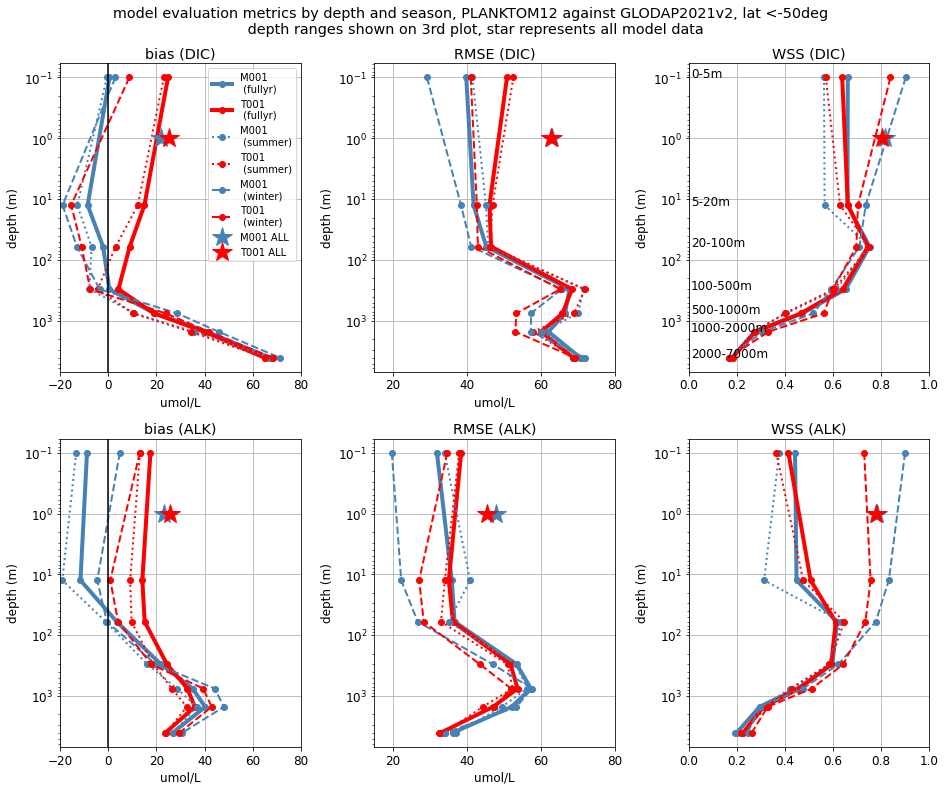

In [209]:
import matplotlib.ticker as mticker
depthmins = np.array([0.0,5,20,100,500,1000,2000])
depthmaxs = np.array([5.0,20,100,500,1000,2000,7000])
depth_tp = np.array([0.1, 12.5,60,300,750,1500,4000])
td = 1; ms = 20; lw = 2
fact = 0.7
fig, axs = plt.subplots(2,3, figsize=(19*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,7):
    axs[2].text(0.01, depth_tp[i],f'{int(depthmins[i])}-{int(depthmaxs[i])}m')


axs[0].plot(bias_bydepth_M001_DIC,depth_tp, color = mcol , marker = 'o', linewidth = lw+2, label='M001\n (fullyr)')
axs[0].plot(bias_bydepth_T001_DIC,depth_tp, color = tcol , marker = 'o', linewidth = lw+2, label='T001\n (fullyr)')
axs[1].plot(RMSE_bydepth_M001_DIC,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[1].plot(RMSE_bydepth_T001_DIC,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[2].plot(WSS_bydepth_M001_DIC,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[2].plot(WSS_bydepth_T001_DIC,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[0].plot(bias_bydepth_M001_DIC_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':', label = 'M001 \n (summer)')
axs[0].plot(bias_bydepth_T001_DIC_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':', label = 'T001 \n (summer)')
axs[1].plot(RMSE_bydepth_M001_DIC_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[1].plot(RMSE_bydepth_T001_DIC_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[2].plot(WSS_bydepth_M001_DIC_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[2].plot(WSS_bydepth_T001_DIC_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[0].plot(bias_bydepth_M001_DIC_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--', label = 'M001 \n (winter)')
axs[0].plot(bias_bydepth_T001_DIC_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--', label = 'T001 \n (winter)')
axs[1].plot(RMSE_bydepth_M001_DIC_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[1].plot(RMSE_bydepth_T001_DIC_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[2].plot(WSS_bydepth_M001_DIC_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[2].plot(WSS_bydepth_T001_DIC_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')

axs[0].plot(bias_M001_DIC,td, color = mcol , marker = '*', markersize = ms, linestyle = '', label = 'M001 ALL')
axs[0].plot(bias_T001_DIC,td, color = tcol , marker = '*', markersize = ms, linestyle = '', label = 'T001 ALL')
axs[1].plot(RMSE_M001_DIC,td, color = mcol , marker = '*', markersize = ms)
axs[1].plot(RMSE_T001_DIC,td, color = tcol , marker = '*', markersize = ms)
axs[2].plot(WSS_M001_DIC,td, color = mcol , marker = '*', markersize = ms)
axs[2].plot(WSS_T001_DIC,td, color = tcol , marker = '*', markersize = ms)

#####
axs[3].plot(bias_bydepth_M001_ALK,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[3].plot(bias_bydepth_T001_ALK,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[4].plot(RMSE_bydepth_M001_ALK,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[4].plot(RMSE_bydepth_T001_ALK,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[5].plot(WSS_bydepth_M001_ALK,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[5].plot(WSS_bydepth_T001_ALK,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[3].plot(bias_bydepth_M001_ALK_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[3].plot(bias_bydepth_T001_ALK_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[4].plot(RMSE_bydepth_M001_ALK_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[4].plot(RMSE_bydepth_T001_ALK_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[5].plot(WSS_bydepth_M001_ALK_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[5].plot(WSS_bydepth_T001_ALK_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[3].plot(bias_bydepth_M001_ALK_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[3].plot(bias_bydepth_T001_ALK_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[4].plot(RMSE_bydepth_M001_ALK_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[4].plot(RMSE_bydepth_T001_ALK_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[5].plot(WSS_bydepth_M001_ALK_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[5].plot(WSS_bydepth_T001_ALK_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')

axs[3].plot(bias_M001_ALK,td, color = mcol , marker = '*', markersize = ms)
axs[3].plot(bias_T001_ALK,td, color = tcol , marker = '*', markersize = ms)
axs[4].plot(RMSE_M001_ALK,td, color = mcol , marker = '*', markersize = ms)
axs[4].plot(RMSE_T001_ALK,td, color = tcol , marker = '*', markersize = ms)
axs[5].plot(WSS_M001_ALK,td, color = mcol , marker = '*', markersize = ms)
axs[5].plot(WSS_T001_ALK,td, color = tcol , marker = '*', markersize = ms)

axs[0].axvline(x=0,color = 'k', linestyle = '-')
axs[3].axvline(x=0,color = 'k', linestyle = '-')

axs[0].legend(loc = 'best', fontsize = 10)

tits= ['bias (DIC)', 'RMSE (DIC)', 'WSS (DIC)','bias (ALK)', 'RMSE (ALK)', 'WSS (ALK)']
xlb= ['umol/L', 'umol/L', '','umol/L', 'umol/L', '']
xmi = [-20,15,0,-20,15,0]; xma = [80,80,1,80,80,1]
for i in range(0,6):
    axs[i].set_yscale('log')
    axs[i].invert_yaxis()
    axs[i].grid(); axs[i].set_title(tits[i])
    axs[i].set_xlim([xmi[i],xma[i]])
    axs[i].set_xlabel(xlb[i])
    axs[i].set_ylabel('depth (m)')
    
fig.suptitle('model evaluation metrics by depth and season, PLANKTOM12 against GLODAP2021v2, lat <-50deg \n depth ranges shown on 3rd plot, star represents all model data')
plt.tight_layout()
#axs[0].yaxis.set_major_formatter(mticker.ScalarFormatter())


In [210]:
print('  compute complete: beep boop ')

  compute complete: beep boop 
